# Mapping Lidar or Radar pointClouds into image frame

In [1]:
import cv2
import numpy as np
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
from matplotlib import rcParams
from pyquaternion import Quaternion
from PIL import Image
import os.path as osp

from nuscenes.nuscenes import NuScenes
from nuscenes.utils.geometry_utils import view_points
from nuscenes.utils.data_classes import LidarPointCloud
from nuscenes.utils.data_classes import RadarPointCloud

from typing import Tuple, List, Dict

%matplotlib inline

## Importing nuScenes dataset

In [2]:
nusc = NuScenes(version='v1.0-mini', dataroot='/home/sherlock/Documents/nuScenes/data', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.5 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


## Mapping points to image frame

The following method deals with the mapping of pointClouds, regarless its source, to the image frame. 

<img src='assets/transformations.jpg' width=440 />

Above are presented the different transformations presented in the method below. Note that everything has to first pass for the global coordinate frame system before gettin into the interest sensor.

In [22]:
def map_pointcloud_to_image(pointsensor_token: str,
                            camera_token: str,
                            min_dist: float = 1.0,
                            render_intensity: bool = False) -> Tuple:
        """
        Given a point sensor (lidar/radar) token and camera sample_data token, load point-cloud and map it to the image
        plane.
        :param pointsensor_token: Lidar/radar sample_data token.
        :param camera_token: Camera sample_data token.
        :param min_dist: Distance from the camera below which points are discarded.
        :param render_intensity: Whether to render lidar intensity instead of point depth.
        :return (pointcloud <np.float: 2, n)>, coloring <np.float: n>, image <Image>).
        """
        cam = nusc.get('sample_data', camera_token) # Sample camera info
        pointsensor = nusc.get('sample_data', pointsensor_token) # Sample point cloud
        # pcl_path is the path from root to the pointCloud file
        pcl_path = osp.join(nusc.dataroot, pointsensor['filename']) 
        # Open the pointCloud path using the Lidar or Radar class
        if pointsensor['sensor_modality'] == 'lidar':
            # Read point cloud with LidarPointCloud (4 x samples) --> X, Y, Z and intensity
            pc = LidarPointCloud.from_file(pcl_path)
            # To access the points pc.points
        else:
            # Read point cloud with LidarPointCloud (18 x samples) --> 
            # https://github.com/nutonomy/nuscenes-devkit/blob/master/python-sdk/nuscenes/utils/data_classes.py#L296
            pc = RadarPointCloud.from_file(pcl_path)
                        
        # Open image of the interest camera
        im = Image.open(osp.join(nusc.dataroot, cam['filename']))

        # Points live in the point sensor frame. So they need to be transformed via global to the image plane.
        # First step: transform the point-cloud to the ego vehicle frame for the timestamp of the sweep.
        cs_record = nusc.get('calibrated_sensor', pointsensor['calibrated_sensor_token']) # Transformation matrix of pointCloud
        # Transform the Quaternion into a rotation matrix and use method rotate in PointCloud class to rotate
        # Map from the laser sensor to ego_pose
        # The method is a dot product between cs_record['rotation'] (3 x 3) and points (3 x points)
        pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix)
        # Add the traslation vector between ego vehicle and sensor
        # The method translate is an addition cs_record['translation'] (3,) and points (3 x points)
        pc.translate(np.array(cs_record['translation']))

        # Second step: transform to the global frame.
        poserecord = nusc.get('ego_pose', pointsensor['ego_pose_token'])
        # Same step as before, map from ego_pose to world coordinate frame
        pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix)
        pc.translate(np.array(poserecord['translation']))

        # Third step: transform into the ego vehicle frame for the timestamp of the image.
        poserecord = nusc.get('ego_pose', cam['ego_pose_token'])
        # Same step as before, map from world coordinate frame to ego vehicle frame for the timestamp of the image.
        pc.translate(-np.array(poserecord['translation']))
        pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix.T)

        # Fourth step: transform into the camera.
        cs_record = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
        # Same step as before, map from ego at camera timestamp to camera
        pc.translate(-np.array(cs_record['translation']))
        pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix.T)

        # Fifth step: actually take a "picture" of the point cloud.
        # Grab the depths (camera frame z axis points away from the camera).
        depths = pc.points[2, :]

        if render_intensity:
            assert pointsensor['sensor_modality'] == 'lidar', 'Error: Can only render intensity for lidar!'
            # Retrieve the color from the intensities.
            # Performs arbitary scaling to achieve more visually pleasing results.
            intensities = pc.points[3, :]
            intensities = (intensities - np.min(intensities)) / (np.max(intensities) - np.min(intensities))
            intensities = intensities ** 0.1
            intensities = np.maximum(0, intensities - 0.5)
            coloring = intensities
        else:
            # Retrieve the color from the depth.
            coloring = depths

        # Take the actual picture (matrix multiplication with camera-matrix + renormalization).
        # Normalization means to divide the X and Y coordinates by the depth
        # The output dim (3 x n_points) where the 3rd row are ones.
        points = view_points(pc.points[:3, :], np.array(cs_record['camera_intrinsic']), normalize=True)

        # Remove points that are either outside or behind the camera. Leave a margin of 1 pixel for aesthetic reasons.
        # Also make sure points are at least 1m in front of the camera to avoid seeing the lidar points on the camera
        # casing for non-keyframes which are slightly out of sync.
        # Create a mask of bools the same size of depth points
        mask = np.ones(depths.shape[0], dtype=bool)
        # Keep points that are at least 1m in front of the camera 
        mask = np.logical_and(mask, depths > min_dist)
        # Keep points such as X coordinate is bigger than 1
        mask = np.logical_and(mask, points[0, :] > 1)
        # remove points such as X coordinate is bigger than image width - 1
        mask = np.logical_and(mask, points[0, :] < im.size[0] - 1)
        # Keep points such as Y coordinate is bigger than 1
        mask = np.logical_and(mask, points[1, :] > 1)
        # remove points such as Y coordinate is bigger than image height - 1
        mask = np.logical_and(mask, points[1, :] < im.size[1] - 1)
        # Keep only the interest points
        points = points[:, mask]
        coloring = coloring[mask]
        
        return points, coloring, im

This method renders the pointCloud provided in map_pointcloud_to_image to the camera image frame

In [21]:
def render_pointcloud_in_image(sample_token: str,
                               dot_size: int = 5,
                               pointsensor_channel: str = 'LIDAR_TOP',
                               camera_channel: str = 'CAM_FRONT',
                               out_path: str = None,
                               render_intensity: bool = False) -> None:
    """
    Scatter-plots a point-cloud on top of image.
    :param sample_token: Sample token (It has to be a sample).
    :param dot_size: Scatter plot dot size.
    :param pointsensor_channel: RADAR or LIDAR channel name, e.g. 'LIDAR_TOP'.
    :param camera_channel: Camera channel name, e.g. 'CAM_FRONT'.
    :param out_path: Optional path to save the rendered figure to disk.
    :param render_intensity: Whether to render lidar intensity instead of point depth.
    """
    sample_record = nusc.get('sample', sample_token)

    # Here we just grab the front camera and the point sensor.
    pointsensor_token = sample_record['data'][pointsensor_channel] # Laser sensor token
    camera_token = sample_record['data'][camera_channel] # Camera sensor token

    points, coloring, im = map_pointcloud_to_image(pointsensor_token, camera_token,
                                                        render_intensity = render_intensity)
        
    # Print pointCloud
    plt.figure(figsize=(9, 16))
    plt.imshow(im)
    plt.scatter(points[0, :], points[1, :], c = coloring, s = dot_size)
    plt.axis('off')

    if out_path is not None:
        plt.savefig(out_path)

## Basic usage

### Mapping the Lidar Point Cloud to the image frame

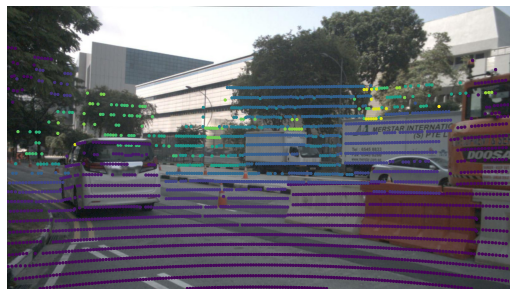

In [23]:
# Obtain a sample from the dataset
my_sample = nusc.sample[20]
# Render the pointCloud of the curren sample in the image frame
render_pointcloud_in_image(my_sample['token'], pointsensor_channel = 'LIDAR_TOP', camera_channel = 'CAM_FRONT')

In [25]:
# The following dict shows the sensors available in the current sample
#my_sample
my_sample['data']

{'RADAR_FRONT': 'e0f3cb9fbae54181945426deed69b4f6',
 'RADAR_FRONT_LEFT': 'a3089ec8a1474912b0036efabf5de2c8',
 'RADAR_FRONT_RIGHT': 'c594463c47074c36acde042dd5a70589',
 'RADAR_BACK_LEFT': 'c721fd748a8c42a7895b1c46f2861689',
 'RADAR_BACK_RIGHT': 'dcb7048f5d07482d8404e904db0fe3ce',
 'LIDAR_TOP': 'e28319b88b634a2d9eff6fdfa7db5500',
 'CAM_FRONT': '06c1523315b14aa7a0dfa4afacafb9e6',
 'CAM_FRONT_RIGHT': '3506e20ade194650955df2c57a69dc21',
 'CAM_BACK_RIGHT': '5e7fa7c26fc04a6fa3358d6dc1e58786',
 'CAM_BACK': '02baa363c8654cf596d30ffce14f5b41',
 'CAM_BACK_LEFT': 'c70904cec6824a4c99bf48ff7973dffb',
 'CAM_FRONT_LEFT': '2a6f34470d6e42808e4eb8e67eedf6a2'}

### Mapping the filtered Radar Point Cloud to the image frame

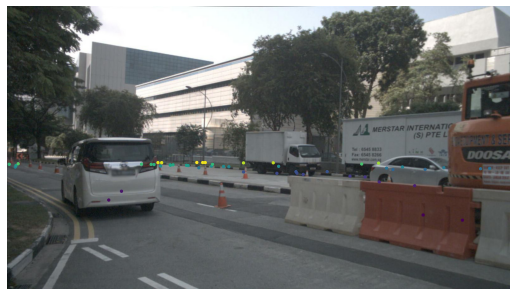

In [26]:
# Rendering the radar Point cloud in the image frame
render_pointcloud_in_image(my_sample['token'], pointsensor_channel='RADAR_FRONT', camera_channel = 'CAM_FRONT')

### Mapping the raw Radar Point Cloud to the image frame

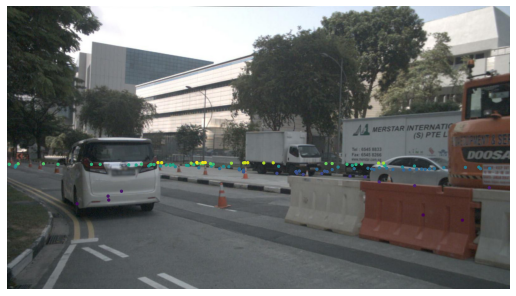

In [27]:
RadarPointCloud.disable_filters()
render_pointcloud_in_image(my_sample['token'], pointsensor_channel='RADAR_FRONT', camera_channel = 'CAM_FRONT')
RadarPointCloud.default_filters()